In [1]:
import numpy as np
import json 
import pickle
import matplotlib.pyplot as plt
import sklearn
from operator import itemgetter


In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from random import randrange


spark = SparkSession.builder \
    .appName(                                 "wc-l") \
    .master(                                   "yarn") \
    .config(             "spark.executor.memory", "7g") \
    .config(                "spark.executor.cores", "2") \
    .config(                 "spark.driver.memory", "1g") \
    .config(    "spark.dynamicAllocation.enabled", "true") \
    .config(  "spark.dynamicAllocation.maxExecutors", "20") \
    .config("spark.dynamicAllocation.initialExecutors", "2") \
    .config(       'spark.ui.port', randrange(4040, 4440, 5)) \
    .getOrCreate()

print(spark.conf.get("spark.driver.appUIAddress"))
sc = spark.sparkContext


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/08 12:39:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/08 12:39:34 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
25/05/08 12:39:46 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Attempted to request executors before the AM has registered!


http://iccluster031.iccluster.epfl.ch:4100


In [3]:
# Loading the datasets
data_movies = sc.textFile("ix-data/ml-20m/movies.txt").map(json.loads)
movie2title = dict(data_movies.map(itemgetter("movieId", "title")).collect())
movie2genres = dict(data_movies.map(itemgetter("movieId", "genres")).collect())

data_tags = sc.textFile("ix-data/ml-20m/genome-tags.txt").map(json.loads)
tag2name = dict(data_tags.map(itemgetter("tagId", "tag")).collect())

data_scores = sc.textFile("ix-data/ml-20m/genome-scores.txt").map(json.loads)
mapping = data_scores.map(lambda x: (x["movieId"], (x["tagId"], x["relevance"])))

movie2tag_score = dict(mapping.groupByKey().mapValues(lambda tag_score: dict(tag_score)).collect())

data_ratings = sc.textFile("ix-data/ml-20m/ratings.txt").map(json.loads)
mapping = data_ratings.map(lambda x: (x["userId"], (x["movieId"], [x["timestamp"], x["rating"]])))
user2movie_rating = dict(mapping.groupByKey().mapValues(lambda ratings: dict(ratings)).collect())



In [4]:
# computation of lenghts of dictionaries

num_movies = len(movie2title)
num_tags = len(tag2name)
num_tag_scores = sum(len(tags) for tags in movie2tag_score.values())
num_ratings = sum(len(ratings) for ratings in user2movie_rating.values())
num_movies_with_tag = len(movie2tag_score)
print(f"There are {num_movies_with_tag} movies with at least one tag.")


There are 10381 movies with at least one tag.


In [5]:
#other useful function (for data understanding)
def num_genres():
    genres = set()
    for i in movie2genres.values():
        genres = genres | set(i)
    num_genres = len(genres)
    print(f"There are {num_genres} different movie genres.")
def movie_title_length():
    length = np.array([len(title) for title in movie2title.values()])
    shortest_ind = np.argmin(length)
    longest_ind = np.argmax(length)
    print(f"The shortest movie title is {list(movie2title.values())[shortest_ind]} with the length {length[shortest_ind]}.")
    print(f"The longest movie title is {list(movie2title.values())[longest_ind]} with the length {length[longest_ind]}.")
def tag_name_length():
    length = np.array([len(title) for title in tag2name.values()])
    shortest_ind = np.argmin(length)
    longest_ind = np.argmax(length)
    print(f"\nThe shortest tag name is {list(tag2name.values())[shortest_ind]} with the length {length[shortest_ind]}.")
    print(f"The longest tag name is {list(tag2name.values())[longest_ind]} with the length {length[longest_ind]}.")

In [6]:
num_genres()
movie_title_length()
tag_name_length()

There are 20 different movie genres.
The shortest movie title is M (1931) with the length 8.
The longest movie title is Godzilla, Mothra, and King Ghidorah: Giant Monsters All-Out Attack (Gojira, Mosura, Kingu Gidorâ: Daikaijû sôkôgeki) (Godzilla, Mothra and King Ghidorah: Giant Monsters All-Out Attack) (2001) with the length 191.

The shortest tag name is 3d with the length 2.
The longest tag name is oscar (best writing - screenplay written directly for the screen) with the length 65.


# Exercise 3.1: 
Constructing the data matrix:

In [7]:
#defining the necessery data types
data_mat = np.zeros((num_tags, num_movies_with_tag))
movie_with_tag_list = list(movie2tag_score.keys())
tag_list = list(tag2name.keys())


#filling up matrice with relevance values
for movie_ind in range(num_movies_with_tag):
    for tag, score in movie2tag_score[movie_with_tag_list[movie_ind]].items():
        data_mat[tag_list.index(tag), movie_ind] = score
        
#printing the resulting matrice (M:number of tags X N: number of movies)
print("Data matrix:")
print(data_mat)
print("Data matrix shape:")
print(data_mat.shape)
print()

# performing matrix multiplication and SVD on rotated and centered matrix 
data_mat_s = data_mat.T
normed = data_mat_s - np.mean(data_mat_s, axis=0) 
cov_mat = (normed.T@normed) / data_mat_s.shape[0]
(e_val,e_vec) = np.linalg.eigh(cov_mat)

#Verifying correct dimentionality
print("Verifying dimensions of covariance matrix, eigenvectors and eigenvalues.")
print("Covariance matrix shape:")
print(cov_mat.shape)
print("Eigenvector shape:")
print(e_vec.shape)
print("Eigenvalue shape:")
print(e_val.shape)
    

Data matrix:
[[0.02125 0.0365  0.018   ... 0.0225  0.04325 0.0365 ]
 [0.0205  0.0385  0.019   ... 0.02175 0.0325  0.04   ]
 [0.031   0.02925 0.041   ... 0.04525 0.01875 0.01825]
 ...
 [0.01275 0.01675 0.006   ... 0.01775 0.0065  0.084  ]
 [0.18775 0.058   0.08075 ... 0.07375 0.21275 0.08075]
 [0.032   0.015   0.01675 ... 0.01775 0.02175 0.016  ]]
Data matrix shape:
(1128, 10381)

Verifying dimensions of covariance matrix, eigenvectors and eigenvalues.
Covariance matrix shape:
(1128, 1128)
Eigenvector shape:
(1128, 1128)
Eigenvalue shape:
(1128,)


In [8]:
# function plotting the variance distribution across tags
# param: matrice: data matrice to calculate variance from (by row)
#        number: number of rows to show 

def tag_variance_plot(matrice,number):
    variance_tags = np.var(matrice,axis=1)
    n = min(number,matrice.shape[0])
    sample = np.flip(np.argsort(variance_tags))[:n]
    tags = np.array(list(tag2name.values()))
    plt.figure(figsize=(12,6))
    plt.barh(tags[sample],variance_tags[sample])
    plt.title("Tag influence on movies")
    plt.ylabel("Tag name")
    plt.xlabel("variance on normalized movies")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# function displaying largest eigenvalues on a log scale
# param: number: number of eigenvalues to display 
    
def eigenvalue_log_plot(number):
    n = min(number,e_val.shape[0])
    plt.figure(figsize=(12,6))
    plt.stem(np.flip(e_val)[:n])
    plt.title("Eigenvalues of MxM cov matrix")
    plt.xlabel("Number")
    plt.ylabel("Eigenvalue")
    plt.yscale('log')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# displays the number of principal components needed to reach a certain fraction of total variability
# param: frac: targetted fraction of total_variability 
def low_dim(frac):
    terms = 0
    variability = 0
    total_var = np.sum(e_val)
    while(variability<total_var*frac):
        variability += np.flip(e_val)[terms]
        terms += 1
    return terms

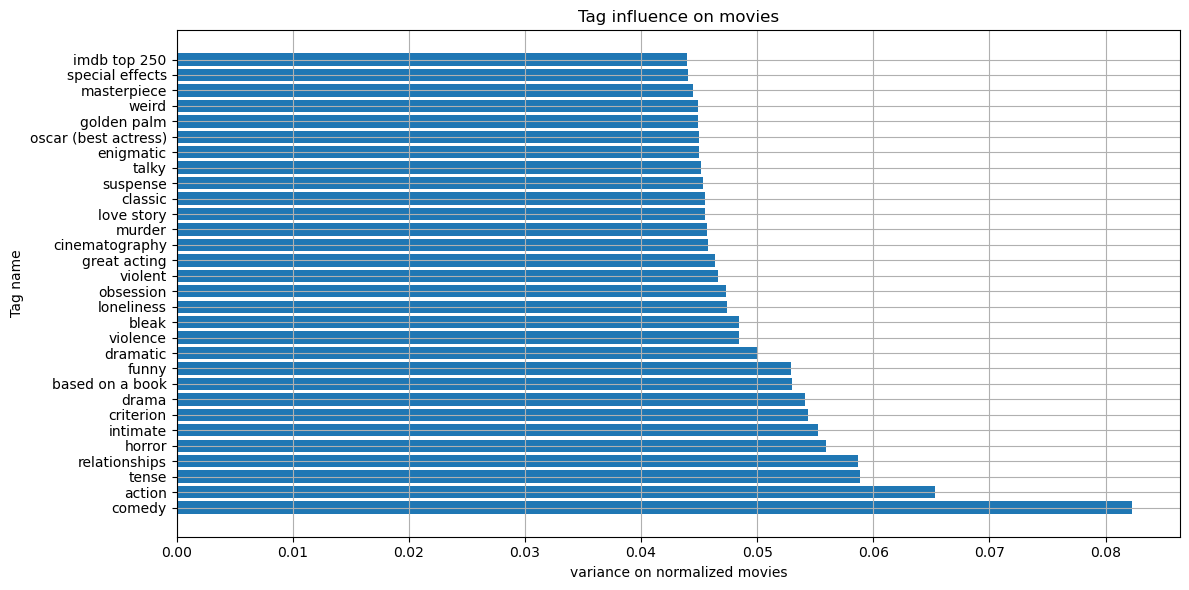

In [9]:
tag_variance_plot(data_mat,30)

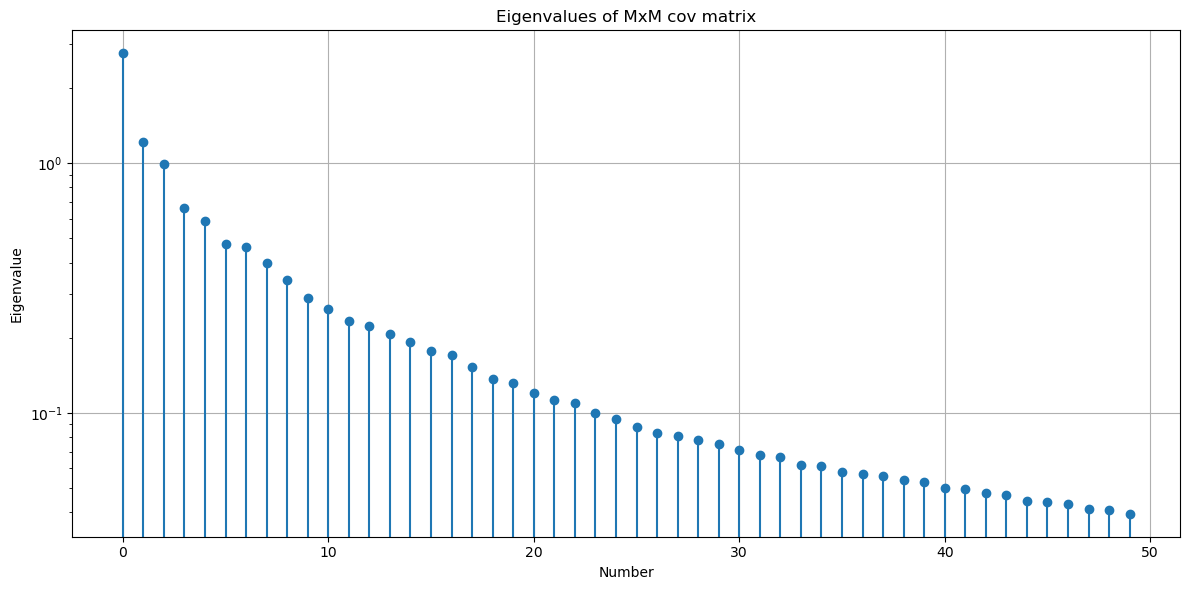

In [10]:
eigenvalue_log_plot(50)

In [11]:
list_ = [1/2,0.67,3/4,9/10]
for i in list_:
    print("Number of Principal directions needed to capture",i,"of the variability is:",low_dim(i))

Number of Principal directions needed to capture 0.5 of the variability is: 12
Number of Principal directions needed to capture 0.67 of the variability is: 38
Number of Principal directions needed to capture 0.75 of the variability is: 76
Number of Principal directions needed to capture 0.9 of the variability is: 331


As we can see, we need a fairly low amount of principal direction to capture most of data variability. It was found that with only 38 out of 1128 directions we will take into account 2/3 of variability. This is also alluded to by the eigenvalue plot of the covariance matrix: eigenvalues beyond the 20th are less than a tenth of what the 1st and 2nd. This implies that the data is not distributed over the 1128 tags randomly, meaning that dimentionality reduction is indeed very applicable on this dataset, and can be applied to retain its essential features, while strongly cutting down on the amount of data that contributes little to the variability. 
    

# Exercise 3.2

In [12]:
#function displaying the tags with the highest and lowest values in the principle components
# params: number_c : number of principal directions to calculate
#         number_t : number of tags to take from each direction (positive and negative)
tag_name = np.array(list(tag2name.values()))
def principal_components(number_c,number_t):
    
    n_c = min(number_c,e_vec.shape[0])
    n_t = min(number_t,e_vec.shape[0])
    
    for i in range(n_c):
        j = len(tag_name)-1-i
        print("For Principal Component",i+1,":")
        principal = e_vec[:,j]
        top_ten_ind = np.flip(np.argsort(principal))[:n_t]
        bottom_ten_ind = np.argsort(principal)[:n_t]
        
        print("positive:")
        for indice in top_ten_ind:
            print(f"\"{tag_name[indice]}\" tag contributes {e_vec[indice][j]*e_val[j]}.")
        print(f"\n")
        
        print("negative:")
        for indice in bottom_ten_ind:
            print(f"\"{tag_name[indice]}\" tag contributes {e_vec[indice][j]*e_val[j]}.")
        print(f"\n")

In [13]:
principal_components(5,10)

For Principal Component 1 :
positive:
"talky" tag contributes 0.28793972241907967.
"social commentary" tag contributes 0.2804134524901909.
"criterion" tag contributes 0.2791347020144147.
"imdb top 250" tag contributes 0.2750535344104773.
"great acting" tag contributes 0.271909261591035.
"drama" tag contributes 0.27097564174544525.
"oscar (best directing)" tag contributes 0.26820613835333385.
"bleak" tag contributes 0.26610609399440993.
"dramatic" tag contributes 0.2648103822491216.
"cinematography" tag contributes 0.2640187022665806.


negative:
"predictable" tag contributes -0.22941899830952592.
"so bad it's funny" tag contributes -0.1884495371980199.
"bad plot" tag contributes -0.1791118443646933.
"silly" tag contributes -0.1691830104595496.
"silly fun" tag contributes -0.16781941405871434.
"horrible" tag contributes -0.15082386945081072.
"franchise" tag contributes -0.14800568853781482.
"lame" tag contributes -0.12733103718755204.
"big budget" tag contributes -0.1260748959780057.
"c

Having looked through the tags returned for each principal direction and their respective weights, I think that the most intuitive description for the first five of them whould be the following:

* Concept 1 : Highly praised by critics, social documentary, fame VS silly, low-budget, local 
* Concept 2 : Relationships, drama, romantic VS action, thriller, fights
* Concept 3 : Romantic, girly, love story VS horror, revolting, shocking
* Concept 4 : Beautiful, utopian VS gore, down-to-earth, dystopian
* Concept 5 : Suspensful thriller, crime VS commedic, family oriented

I am quite satisfied with those results as I think that they make a lot of sence in respect of the movie industry.


In [14]:
# Saving a map between tag ids and coordinates in the principal directions

#function returning the mapping of every tag onto the principal directions and saving it to disk
# param: number: number of principal direction to map to. 
# return a dict mapping the tag IDs to a list the ith component of which is the tag's coordinate in the ith principal direction
def tag_mapping(number):
    n = min(number,e_vec.shape[0])
    tag_mapping_to_pca = dict()
    col = len(tag_name) -1 
    
    for i in range(len(tag_name)):
        values = list()
        for j in range(n):
            values.append(e_vec[i,col-j]*e_val[col-j])
        tag_mapping_to_pca[tag_name[i]] = values
    
    with open('tag_mapping.pkl', 'wb') as f:
        pickle.dump(tag_mapping_to_pca, f)
        
    return tag_mapping_to_pca   
    
# stores the mapping of all tags to all p.c. each function can then specify the chunck of mapping_all to use based on it's needs   
mapping_all = tag_mapping(len(e_val))

# Exercise 3.3

In [15]:
# imports of bokeh and related functionality 
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool, ColorBar, LinearColorMapper

output_notebook()

%matplotlib inline
plt.style.use("ggplot")
from matplotlib.colors import rgb2hex 
cmap = plt.get_cmap('viridis')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

# import of data sample
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")


Loading BokehJS ...

In [16]:
# function preparing data for representation in 2D using bokeh from the "movies" list
# param: num_comp : number of principal direction to map tags to (using tag_mapping)
#        x: principal direction that will define the x-axis (must be smaller than num_comp)
#        y: principal direction that will define the y-axis (must be smaller than num_comp)
#        relevamnce: cut-off value to consider a tag to belong to a movie (between 0 and 1) 
def TwoD_map_data_movies(x,y,relevance):
    data = []
    x = min(x,len(e_val))
    y = min(y,len(e_val))
    
    for m in movies:
        coord1 = 0
        coord2 = 0 
        local_dict = movie2tag_score.get(m[0])
        
        for ID in local_dict.keys():
            if local_dict.get(ID) > relevance:
                coord1 += mapping_all.get(tag2name.get(ID))[x-1]
                coord2 += mapping_all.get(tag2name.get(ID))[y-1]
                
        data.append((coord1,coord2,m[1],m[2]))
    return data

In [17]:
#plotting data in bokeh
mapping = TwoD_map_data_movies(1,2,0.5)
source = ColumnDataSource(
    data={
        "PCA1": [x[0] for x in mapping],
        "PCA2": [x[1] for x in mapping],
        "name": [x[2] for x in mapping],
        "RottenScore": [val2rgb(x[3]) for x in mapping],
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(width=960, height=360, tools=tools, title="First two PCA directions of selected movies",x_axis_label='PC 1', y_axis_label='PC 2')
p.circle("PCA1", "PCA2", source=source, size=20, color="RottenScore", alpha=0.5)


show(p, notebook_handle=True)

Let's analyse the results. We have an interesting set of highly praised movies at bottom center of the plot. They are (from left to right): 
* Jurastic Parc
* Edge of Tomorrow
* Terminator
* Star Wars: Episode IV

These movies all score very low in the second principle component which makes sence since they are all thrillers, contain fights, etc...
They also all score positive on the first principle component because of their global fame and recognition.
Taking a movie located on the top-left of the graph, "Just My Luck" we can hypothesise that it is a shady romance movie based on it's high score in PC2 and low score in PC1. That turns out to be indeed the case.

It is interesting to notice that the rotten tomatoes score seem to be independent with the position of the movie on the y-axis. On the other hand, movies with a low x coordinate tend to have worser scores than those with a high x coordinate. This makes sence, popular high-budget movies tend to have better reviews while the genre of the movie (romantic VS action) doesn't have so much weight on it's quality.

# Exercise 3.4:

In [18]:

#preparing necessary data structures
tsne = sklearn.manifold.TSNE(init="pca")
pca_matrix = np.zeros((len(movie2tag_score),50))
i = j = 0
data = []


#building pca matrix 
for m in movie2tag_score:
    coords = [0] * 50
    for ID in movie2tag_score.get(m):
        if movie2tag_score.get(m).get(ID) > 0.5:
            for i in range(len(coords)):
                coords[i] += mapping_all.get(tag2name.get(ID))[i]
    pca_matrix[i] = coords
    i+=1
#turning pca matrix to tsne coords                
tsne_result = tsne.fit_transform(pca_matrix)

#generating data array for visualisation
for m in movie2tag_score:
    tag_name = []
    top_tagID = sorted(movie2tag_score.get(m),key = movie2tag_score.get(m).get, reverse = True)[:5]
    for tagID in top_tagID:
        tag_name.append(tag2name.get(tagID))
    
    data.append((movie2title.get(m), tsne_result[j][0], tsne_result[j][1],tag_name))
    j+= 1   

In [ ]:
#plotting data in bokeh
mapping = data
source = ColumnDataSource(
    data={
        "coord1": [x[1] for x in mapping],
        "coord2": [x[2] for x in mapping],
        "tags": [x[3] for x in mapping],
    })

hover = HoverTool(
    tooltips=[
        ("tags", "@tags"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(width=960, height=360, tools=tools, title="t-SNE applied on PCA",x_axis_label='Coord 1', y_axis_label='Coord 2')
p.circle("coord1", "coord2", source=source, size=20, color="blue", alpha=0.5)


show(p, notebook_handle=True)

In [ ]:
# function preparing data for representation in 2D using bokeh from the "movie2tags_score" dict
# param: num_comp : number of principal direction to map tags to (using tag_mapping)
#        x: principal direction that will define the x-axis (must be smaller than num_comp)
#        y: principal direction that will define the y-axis (must be smaller than num_comp)
#        relevamnce: cut-off value to consider a tag to belong to a movie (between 0 and 1) 
def TwoD_map_data_all_movies(x,y,relevance):
    data = []
    x = min(x,len(e_val))
    y = min(y,len(e_val))
    
    for m in movie2tag_score:
        coord1 = 0
        coord2 = 0 
        
        for ID in movie2tag_score.get(m):
            if movie2tag_score.get(m).get(ID) > relevance:
                coord1 += mapping_all.get(tag2name.get(ID))[x-1]
                coord2 += mapping_all.get(tag2name.get(ID))[y-1]
                
        data.append((coord1,coord2,movie2title.get(m),relevance))
    return data

In [ ]:
import random
mapping = random.sample(TwoD_map_data_all_movies(1,2,0.5),500)
source = ColumnDataSource(
    data={
        "PCA1": [x[0] for x in mapping],
        "PCA2": [x[1] for x in mapping],
        "name": [x[2] for x in mapping],
        "RottenScore": [val2rgb(x[3]) for x in mapping],
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(width=960, height=360, tools=tools, title="First 2 PCA directions of all movies",x_axis_label='PC 1', y_axis_label='PC 2')
p.circle("PCA1", "PCA2", source=source, size=20, color="RottenScore", alpha=0.5)


show(p, notebook_handle=True)

The t-SNE plot provides 3 or 4 very distict clusters of movies, while in the PCA plot they form a rather formless cloud of dots. On the other hand, the coordinates of the clusters in the t-SNE plot are hardly interpretable and don't offer much insight. This happens because t-SNE converts high dimentional vectors into probabilities and works on preserving the distance of similar vectors small while disregarding relationships of distant vectors. t-SNE is agnostic to the  meaning of the high dimentional vectors is effective at categorising large sets of data. 